# Session 2 - Parameter Calibration

Let's import BattMo and some other packages into the kernel.

In [6]:
using BattMo, GLMakie, CSV, DataFrames, Jutul

This example demonstrates how to calibrate a lithium-ion battery against datamodel using BattMo.jl. The example uses a two-step calibration process:
1. We first calibrate the model against a 0.5C discharge curve (adjusting stoichiometric coefficients and maximum concentration in the active material)
2. We then calibrate the model against a 2.0C discharge curve (adjusting reaction rate constants and diffusion coefficients in the active material)

Finally, we compare the results of the calibrated model against the experimental data for discharge rates of 0.5C, 1.0C, and 2.0C.

### Load the experimental data and set up a base case

In [7]:
df_05 = CSV.read("Xu2015_data/Xu_2015_voltageCurve_05C.csv", DataFrame)
df_1 = CSV.read("Xu2015_data/Xu_2015_voltageCurve_05C.csv", DataFrame)
df_2 = CSV.read("Xu2015_data/Xu_2015_voltageCurve_05C.csv", DataFrame)

dfs = [df_05, df_1, df_2]

3-element Vector{DataFrame}:
 20×2 DataFrame
 Row │ 0          3.3861097472267683 
     │ Float64   Float64             
─────┼───────────────────────────────
   1 │  357.766              3.29433
   2 │  715.976              3.26386
   3 │ 1074.19               3.2519
   4 │ 1432.4                3.24463
   5 │ 1790.61               3.24649
   6 │ 2148.82               3.24575
   7 │ 2507.03               3.24625
   8 │ 2877.59               3.24726
   9 │ 3223.45               3.23566
  10 │ 3594.01               3.23518
  11 │ 3952.22               3.23593
  12 │ 4310.43               3.23717
  13 │ 4668.64               3.2278
  14 │ 5026.85               3.22731
  15 │ 5385.06               3.21844
  16 │ 5743.27               3.21746
  17 │ 6101.48               3.19921
  18 │ 6472.04               3.17788
  19 │ 6817.9                2.88079
  20 │ 7188.46               2.17905
 20×2 DataFrame
 Row │ 0          3.3861097472267683 
     │ Float64   Float64             
─────┼─────

In [8]:
cell_parameters = load_cell_parameters(; from_default_set = "Xu2015")
cycling_protocol = load_cycling_protocol(; from_default_set = "CCDischarge")

cycling_protocol["LowerVoltageLimit"] = 2.25
model_setup = LithiumIonBattery()

cycling_protocol["DRate"] = 0.5
sim = Simulation(model_setup, cell_parameters, cycling_protocol)
output0 = solve(sim);



┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\lorenah\.julia\packages\ProgressMeter\kniaW\src\ProgressMeter.jl:607
Progress 100%|███████████████████████████████████████████| Time: 0:00:31


╭────────────────┬───────────┬───────────────┬──────────╮
│ Iteration type │  Avg/step │  Avg/ministep │    Total │
│                │ 138 steps │ 138 ministeps │ (wasted) │
├────────────────┼───────────┼───────────────┼──────────┤
│ Newton         │   2.18841 │       2.18841 │  302 (0) │
│ Linearization  │   3.18841 │       3.18841 │  440 (0) │
│ Linear solver  │   2.18841 │       2.18841 │  302 (0) │
│ Precond apply  │       0.0 │           0.0 │    0 (0) │
╰────────────────┴───────────┴───────────────┴──────────╯
╭───────────────┬─────────┬────────────┬─────────╮
│ Timing type   │    Each │   Relative │   Total │
│               │      ms │ Percentage │       s │
├───────────────┼─────────┼────────────┼─────────┤
│ Properties    │  0.8505 │     1.00 % │  0.2568 │
│ Equations     │ 17.0110 │    29.12 % │  7.4848 │
│ Assembly      │  8.1672 │    13.98 % │  3.5936 │
│ Linear solve  │  1.2527 │     1.47 % │  0.3783 │
│ Linear setup  │  0.0000 │     0.00 % │  0.0000 │
│ Precond apply │  

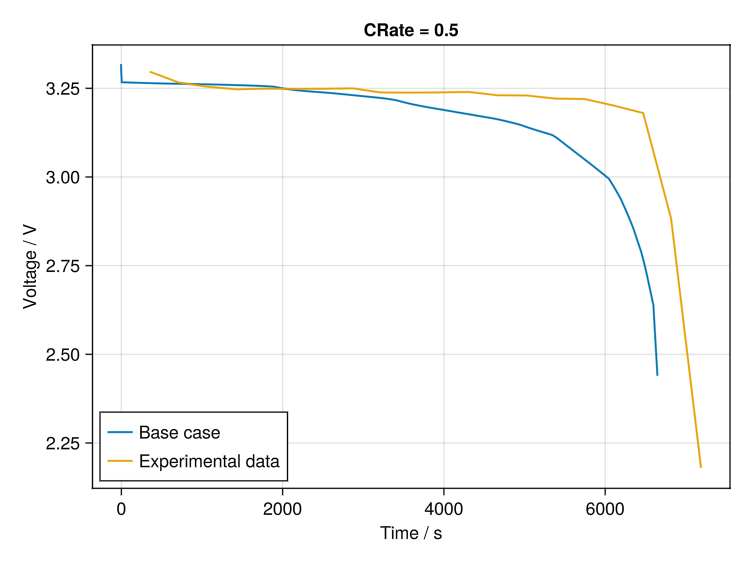

In [9]:
time_series0 = get_output_time_series(output0)

t0 = time_series0[:Time]
V0 = time_series0[:Voltage]

t_exp_05 = df_05[:,1]
V_exp_05 = df_05[:,2]
t_exp_1 = df_1[:,1]
V_exp_1 = df_1[:,2]

fig = Figure()
ax = Axis(fig[1, 1], title = "CRate = 0.5", xlabel = "Time / s", ylabel = "Voltage / V")
lines!(ax, t0, V0, label = "Base case")
lines!(ax, t_exp_05, V_exp_05, label = "Experimental data")
axislegend(position = :lb)
fig

### Set up the first calibration

We select the following parameters to calibrate:
- "StoichiometricCoefficientAtSOC100" at both electrodes
- "StoichiometricCoefficientAtSOC0" at both electrodes
- "MaximumConcentration" of both electrodes

We also set bounds for these parameters to ensure they remain physically meaningful and possible to simulate. The objective function is the sum of squares: ``\sum_i (V_i - V_{exp,i})^2``, where ``V_i`` is the voltage from the model and ``V_{exp,i}`` is the voltage from the experimental data at step ``i``.

We print the setup as a table to give the user the opportunity to review the setup before calibration starts.

In [10]:
calibration_05 = VoltageCalibration(t_exp_05, V_exp_05, sim)

VoltageCalibration([357.76627218934914, 715.9763313609469, 1074.1863905325445, 1432.396449704142, 1790.6065088757396, 2148.816568047337, 2507.0266272189347, 2877.5887573964496, 3223.44674556213, 3594.0088757396447, 3952.2189349112427, 4310.42899408284, 4668.639053254437, 5026.8491124260345, 5385.059171597633, 5743.2692307692305, 6101.479289940828, 6472.041420118343, 6817.899408284024, 7188.461538461537], [3.2943262673632967, 3.2638600156322126, 3.2518999695748874, 3.2446281622882482, 3.246486083133996, 3.245753135185418, 3.246253934281757, 3.2472569925301102, 3.2356583102522136, 3.2351808720466657, 3.2359284205519883, 3.237169467875278, 3.227800290612279, 3.2273140920726844, 3.2184384136276525, 3.217458716270091, 3.1992065602836877, 3.177878797019038, 2.8807910485472883, 2.179051790010771], Simulation(BattMo.run_battery, LithiumIonBattery("Setup object for a P2D lithium-ion model", {
    "RampUp" => "Sinusoidal"
    "Metadata" =>     {
        "Description" => "Default model settings f

In [11]:
print_calibration_overview(calibration_05)

In [12]:
free_calibration_parameter!(calibration_05,
    ["NegativeElectrode","ActiveMaterial", "StoichiometricCoefficientAtSOC100"];
    lower_bound = 0.0, upper_bound = 1.0)
free_calibration_parameter!(calibration_05,
    ["PositiveElectrode","ActiveMaterial", "StoichiometricCoefficientAtSOC100"];
    lower_bound = 0.0, upper_bound = 1.0)

# "StoichiometricCoefficientAtSOC0" at both electrodes
free_calibration_parameter!(calibration_05,
    ["NegativeElectrode","ActiveMaterial", "StoichiometricCoefficientAtSOC0"];
    lower_bound = 0.0, upper_bound = 1.0)
free_calibration_parameter!(calibration_05,
    ["PositiveElectrode","ActiveMaterial", "StoichiometricCoefficientAtSOC0"];
    lower_bound = 0.0, upper_bound = 1.0)

#  "MaximumConcentration" of both electrodes
free_calibration_parameter!(calibration_05,
    ["NegativeElectrode","ActiveMaterial", "MaximumConcentration"];
    lower_bound = 10000.0, upper_bound = 1e5)
free_calibration_parameter!(calibration_05,
    ["PositiveElectrode","ActiveMaterial", "MaximumConcentration"];
    lower_bound = 10000.0, upper_bound = 1e5)

VoltageCalibration([357.76627218934914, 715.9763313609469, 1074.1863905325445, 1432.396449704142, 1790.6065088757396, 2148.816568047337, 2507.0266272189347, 2877.5887573964496, 3223.44674556213, 3594.0088757396447, 3952.2189349112427, 4310.42899408284, 4668.639053254437, 5026.8491124260345, 5385.059171597633, 5743.2692307692305, 6101.479289940828, 6472.041420118343, 6817.899408284024, 7188.461538461537], [3.2943262673632967, 3.2638600156322126, 3.2518999695748874, 3.2446281622882482, 3.246486083133996, 3.245753135185418, 3.246253934281757, 3.2472569925301102, 3.2356583102522136, 3.2351808720466657, 3.2359284205519883, 3.237169467875278, 3.227800290612279, 3.2273140920726844, 3.2184384136276525, 3.217458716270091, 3.1992065602836877, 3.177878797019038, 2.8807910485472883, 2.179051790010771], Simulation(BattMo.run_battery, LithiumIonBattery("Setup object for a P2D lithium-ion model", {
    "RampUp" => "Sinusoidal"
    "Metadata" =>     {
        "Description" => "Default model settings f

In [13]:
print_calibration_overview(calibration_05)

NegativeElectrode: Active calibration parameters
┌──────────────────────────────────────────────────┬───────────────┬────────────────────┐
│                                             Name │ Initial value │             Bounds │
├──────────────────────────────────────────────────┼───────────────┼────────────────────┤
│              ActiveMaterial.MaximumConcentration │         31540 │ 10000.0 - 100000.0 │
│ ActiveMaterial.StoichiometricCoefficientAtSOC100 │      0.518738 │          0.0 - 1.0 │
│   ActiveMaterial.StoichiometricCoefficientAtSOC0 │         0.001 │          0.0 - 1.0 │
└──────────────────────────────────────────────────┴───────────────┴────────────────────┘
PositiveElectrode: Active calibration parameters
┌──────────────────────────────────────────────────┬───────────────┬────────────────────┐
│                                             Name │ Initial value │             Bounds │
├──────────────────────────────────────────────────┼───────────────┼────────────────────┤
│ 

### Solve the first calibration problem

The calibration is performed by solving the optimization problem. This makes use of the adjoint method implemented in Jutul.jl and the LBFGS algorithm.

In [14]:
solve(calibration_05);
cell_parameters_calibrated = calibration_05.calibrated_cell_parameters;


Calibration: Starting calibration of 6 parameters.
It:   0 | val: 3.886e-02 | ls-its: NaN | pgrad: 6.480e+00
It:   1 | val: 1.829e-02 | ls-its: 1 | pgrad: 6.480e+00
It:   2 | val: 4.321e-03 | ls-its: 4 | pgrad: 1.097e+00
It:   3 | val: 4.278e-03 | ls-its: 2 | pgrad: 1.386e-01
It:   4 | val: 4.275e-03 | ls-its: 1 | pgrad: 2.249e-02
It:   5 | val: 4.273e-03 | ls-its: 1 | pgrad: 1.506e-02
It:   6 | val: 4.261e-03 | ls-its: 1 | pgrad: 1.534e-02
It:   7 | val: 4.242e-03 | ls-its: 1 | pgrad: 5.334e-02
It:   8 | val: 4.089e-03 | ls-its: 1 | pgrad: 7.754e-02
LBFGS: Line search unable to succeed in 5 iterations ...
LBFGS: Hessian not updated during iteration 9
It:   9 | val: 3.073e-03 | ls-its: 5 | pgrad: 2.324e-01
LBFGS: Line search unable to succeed in 5 iterations ...
LBFGS: Hessian not updated during iteration 10
It:  10 | val: 3.073e-03 | ls-its: 5 | pgrad: 2.898e-01
Calibration: Calibration finished in 145.9846241 seconds.


In [15]:
print_calibration_overview(calibration_05)

NegativeElectrode: Active calibration parameters
┌──────────────────────────────────────────────────┬───────────────┬────────────────────┬─────────────────┬──────────┐
│                                             Name │ Initial value │             Bounds │ Optimized value │   Change │
├──────────────────────────────────────────────────┼───────────────┼────────────────────┼─────────────────┼──────────┤
│              ActiveMaterial.MaximumConcentration │         31540 │ 10000.0 - 100000.0 │         22039.3 │  -30.12% │
│ ActiveMaterial.StoichiometricCoefficientAtSOC100 │      0.518738 │          0.0 - 1.0 │        0.546901 │    5.43% │
│   ActiveMaterial.StoichiometricCoefficientAtSOC0 │         0.001 │          0.0 - 1.0 │       0.0263285 │ 2532.85% │
└──────────────────────────────────────────────────┴───────────────┴────────────────────┴─────────────────┴──────────┘
PositiveElectrode: Active calibration parameters
┌──────────────────────────────────────────────────┬───────────────┬─

### Compare the results of the calibration against the experimental data

We can now compare the results of the calibrated model against the experimental data for the 0.5C discharge curve.

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\lorenah\.julia\packages\ProgressMeter\kniaW\src\ProgressMeter.jl:607
Progress 100%|███████████████████████████████████████████| Time: 0:00:00


╭────────────────┬───────────┬───────────────┬──────────╮
│ Iteration type │  Avg/step │  Avg/ministep │    Total │
│                │ 145 steps │ 145 ministeps │ (wasted) │
├────────────────┼───────────┼───────────────┼──────────┤
│ Newton         │   2.13103 │       2.13103 │  309 (0) │
│ Linearization  │   3.13103 │       3.13103 │  454 (0) │
│ Linear solver  │   2.13103 │       2.13103 │  309 (0) │
│ Precond apply  │       0.0 │           0.0 │    0 (0) │
╰────────────────┴───────────┴───────────────┴──────────╯
╭───────────────┬────────┬────────────┬──────────╮
│ Timing type   │   Each │   Relative │    Total │
│               │     ms │ Percentage │       ms │
├───────────────┼────────┼────────────┼──────────┤
│ Properties    │ 0.4530 │    30.11 % │ 139.9846 │
│ Equations     │ 0.2071 │    20.22 % │  94.0049 │
│ Assembly      │ 0.0828 │     8.09 % │  37.5868 │
│ Linear solve  │ 0.3381 │    22.47 % │ 104.4669 │
│ Linear setup  │ 0.0000 │     0.00 % │   0.0000 │
│ Precond apply │ 0

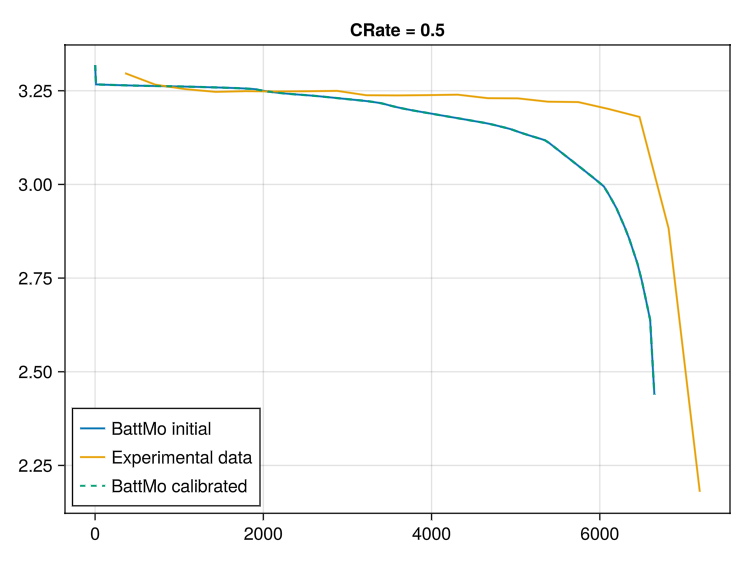

In [16]:
sim_opt = Simulation(model_setup, cell_parameters_calibrated, cycling_protocol)
output_opt = solve(sim_opt);
time_series_opt = get_output_time_series(output0)

t_opt = time_series_opt[:Time]
V_opt = time_series_opt[:Voltage]

fig = Figure()
ax = Axis(fig[1, 1], title = "CRate = 0.5")
lines!(ax, t0, V0, label = "BattMo initial")
lines!(ax, t_exp_05, V_exp_05, label = "Experimental data")
lines!(ax, t_opt, V_opt, label = "BattMo calibrated", linestyle = :dash)
axislegend(position = :lb)
fig

### Set up the second calibration

The second calibration is performed against the 2.0C discharge curve. In the same manner as for the first discharge curve, we set up a set of parameters to calibrate against experimental data. The parameters are:

 - The reaction rate constant of both electrodes
 - The diffusion coefficient of both electrodes

The calibration this time around starts from the parameters calibrated in the first step, so we use the `cell_parameters_calibrated` from the first `solve` call when defining the new object:

In [17]:
t_exp_2 = df_2[:,1]
V_exp_2 = df_2[:,2]

cycling_protocol2 = deepcopy(cycling_protocol)
cycling_protocol2["DRate"] = 2.0

sim2 = Simulation(model_setup, cell_parameters_calibrated, cycling_protocol2)
output2 = solve(sim2);

time_series_2 = get_output_time_series(output2)

t2 = time_series_2[:Time]
V2 = time_series_2[:Voltage]


┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\lorenah\.julia\packages\ProgressMeter\kniaW\src\ProgressMeter.jl:607
Progress 100%|███████████████████████████████████████████| Time: 0:00:00


╭────────────────┬──────────┬──────────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │    Total │
│                │ 34 steps │ 35 ministeps │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┤
│ Newton         │  3.11765 │      3.02857 │  106 (3) │
│ Linearization  │  4.11765 │          4.0 │  140 (3) │
│ Linear solver  │  3.08824 │          3.0 │  105 (2) │
│ Precond apply  │      0.0 │          0.0 │    0 (0) │
╰────────────────┴──────────┴──────────────┴──────────╯


33-element Vector{Float64}:
 3.3124875389076873
 3.2433085388303105
 3.166908993822564
 3.1665792810826034
 3.1658871124047465
 3.1646415186241166
 3.1636231950334768
 3.1624122923441766
 3.1609022845963373
 3.1592496664022915
 3.157095827948833
 3.1541813988786425
 3.1510952797123064
 ⋮
 3.0707207530848337
 3.059191599267797
 3.047124572035369
 3.034320092544745
 3.0215422509350316
 3.003895437967513
 2.9673826331916144
 2.930049838351993
 2.8910893295127034
 2.8137238785442333
 2.690171961121722
 2.4710930939453934

╭───────────────┬────────┬────────────┬──────────╮
│ Timing type   │   Each │   Relative │    Total │
│               │     ms │ Percentage │       ms │
├───────────────┼────────┼────────────┼──────────┤
│ Properties    │ 0.3542 │    11.93 % │  37.5488 │
│ Equations     │ 0.7471 │    33.22 % │ 104.5986 │
│ Assembly      │ 0.0854 │     3.80 % │  11.9575 │
│ Linear solve  │ 0.2137 │     7.20 % │  22.6532 │
│ Linear setup  │ 0.0000 │     0.00 % │   0.0000 │
│ Precond apply │ 0.0000 │     0.00 % │   0.0000 │
│ Update        │ 0.0741 │     2.49 % │   7.8503 │
│ Convergence   │ 0.0890 │     3.96 % │  12.4581 │
│ Input/Output  │ 0.0410 │     0.46 % │   1.4358 │
│ Other         │ 1.0976 │    36.95 % │ 116.3422 │
├───────────────┼────────┼────────────┼──────────┤
│ Total         │ 2.9702 │   100.00 % │ 314.8445 │
╰───────────────┴────────┴────────────┴──────────╯


In [18]:
sim2_0 = Simulation(model_setup, cell_parameters, cycling_protocol2)
output2_0 = solve(sim2_0);
time_series_2_0 = get_output_time_series(output2_0)

t2_0 = time_series_2_0[:Time]
V2_0 = time_series_2_0[:Voltage]

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\lorenah\.julia\packages\ProgressMeter\kniaW\src\ProgressMeter.jl:607
Progress 100%|███████████████████████████████████████████| Time: 0:00:03


╭────────────────┬──────────┬──────────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │    Total │
│                │ 32 steps │ 33 ministeps │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┤
│ Newton         │   3.8125 │      3.69697 │  122 (3) │
│ Linearization  │   4.8125 │      4.66667 │  154 (3) │
│ Linear solver  │  3.78125 │      3.66667 │  121 (2) │
│ Precond apply  │      0.0 │          0.0 │    0 (0) │
╰────────────────┴──────────┴──────────────┴──────────╯
╭───────────────┬─────────┬────────────┬────────╮
│ Timing type   │    Each │   Relative │  Total │
│               │      ms │ Percentage │      s │
├───────────────┼─────────┼────────────┼────────┤
│ Properties    │  0.9409 │     3.57 % │ 0.1148 │
│ Equations     │ 12.3216 │    58.98 % │ 1.8975 │
│ Assembly      │  0.0807 │     0.39 % │ 0.0124 │
│ Linear solve  │  0.1992 │     0.76 % │ 0.0243 │
│ Linear setup  │  0.0000 │     0.00 % │ 0.0000 │
│ Precond apply │  0.0000 │     0.00 % │ 0.000

31-element Vector{Float64}:
 3.305635161843414
 3.225426391755017
 3.1338317851164037
 3.1338536743648477
 3.133765226390686
 3.1330098392381927
 3.1316508894627884
 3.12981224192073
 3.127455628337298
 3.124137151891489
 3.120077198834965
 3.114642993906159
 3.10374355307402
 ⋮
 3.0161132681192884
 2.999791541064191
 2.981473371447777
 2.960138070776812
 2.9420580019823737
 2.9235656646822616
 2.887254546768977
 2.84796332040077
 2.807278724116445
 2.738956766258758
 2.6239062938377016
 2.445107779444795

In [19]:
calibration_2 = VoltageCalibration(t_exp_2, V_exp_2, sim2)

free_calibration_parameter!(calibration_2,
    ["NegativeElectrode","ActiveMaterial", "ReactionRateConstant"];
    lower_bound = 1e-16, upper_bound = 1e-10)
free_calibration_parameter!(calibration_2,
    ["PositiveElectrode","ActiveMaterial", "ReactionRateConstant"];
    lower_bound = 1e-16, upper_bound = 1e-10)

free_calibration_parameter!(calibration_2,
    ["NegativeElectrode","ActiveMaterial", "DiffusionCoefficient"];
    lower_bound = 1e-16, upper_bound = 1e-12)
free_calibration_parameter!(calibration_2,
    ["PositiveElectrode","ActiveMaterial", "DiffusionCoefficient"];
    lower_bound = 1e-16, upper_bound = 1e-12)

print_calibration_overview(calibration_2)

NegativeElectrode: Active calibration parameters
┌─────────────────────────────────────┬───────────────┬───────────────────┐
│                                Name │ Initial value │            Bounds │
├─────────────────────────────────────┼───────────────┼───────────────────┤
│ ActiveMaterial.DiffusionCoefficient │       3.9e-14 │ 1.0e-16 - 1.0e-12 │
│ ActiveMaterial.ReactionRateConstant │     1.764e-11 │ 1.0e-16 - 1.0e-10 │
└─────────────────────────────────────┴───────────────┴───────────────────┘
PositiveElectrode: Active calibration parameters
┌─────────────────────────────────────┬───────────────┬───────────────────┐
│                                Name │ Initial value │            Bounds │
├─────────────────────────────────────┼───────────────┼───────────────────┤
│ ActiveMaterial.ReactionRateConstant │     3.626e-11 │ 1.0e-16 - 1.0e-10 │
│ ActiveMaterial.DiffusionCoefficient │      1.25e-15 │ 1.0e-16 - 1.0e-12 │
└─────────────────────────────────────┴───────────────┴───────────

### Solve the second calibration problem

In [20]:
cell_parameters_calibrated2, = solve(calibration_2);
print_calibration_overview(calibration_2)

Calibration: Starting calibration of 4 parameters.
It:   0 | val: 4.877e-01 | ls-its: NaN | pgrad: 2.352e+02
It:   1 | val: 3.630e-01 | ls-its: 1 | pgrad: 2.351e+02
It:   2 | val: 3.278e-01 | ls-its: 1 | pgrad: 1.928e+01
LBFGS: Line search unable to succeed in 5 iterations ...
It:   3 | val: 3.097e-01 | ls-its: 5 | pgrad: 1.716e+01
LBFGS: Line search unable to succeed in 5 iterations ...
It:   4 | val: 3.068e-01 | ls-its: 5 | pgrad: 1.611e+01
It:   5 | val: 3.038e-01 | ls-its: 3 | pgrad: 1.594e+01
It:   6 | val: 3.008e-01 | ls-its: 5 | pgrad: 1.402e+01
LBFGS: Line search unable to succeed in 5 iterations ...
It:   7 | val: 2.962e-01 | ls-its: 5 | pgrad: 1.245e+01
LBFGS: Line search unable to succeed in 5 iterations ...
It:   8 | val: 2.933e-01 | ls-its: 5 | pgrad: 1.143e+01
LBFGS: Line search unable to succeed in 5 iterations ...
It:   9 | val: 2.931e-01 | ls-its: 5 | pgrad: 1.093e+01
LBFGS: Line search unable to succeed in 5 iterations ...
It:  10 | val: 2.930e-01 | ls-its: 5 | pgrad:

### Compare the results of the second calibration against the experimental data

We can now compare the results of the calibrated model against the experimental data for the 2.0C discharge curve. We compare three simulations against the experimental data:
 1. The initial simulation with the original parameters.
 2. The simulation with the parameters calibrated against the 0.5C discharge curve.
 3. The simulation with the parameters calibrated against the 0.5C and 2.0C discharge curves.

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\lorenah\.julia\packages\ProgressMeter\kniaW\src\ProgressMeter.jl:607
Progress 100%|███████████████████████████████████████████| Time: 0:00:00


╭────────────────┬──────────┬──────────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │    Total │
│                │ 38 steps │ 38 ministeps │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┤
│ Newton         │  3.15789 │      3.15789 │  120 (0) │
│ Linearization  │  4.15789 │      4.15789 │  158 (0) │
│ Linear solver  │  3.15789 │      3.15789 │  120 (0) │
│ Precond apply  │      0.0 │          0.0 │    0 (0) │
╰────────────────┴──────────┴──────────────┴──────────╯
╭───────────────┬────────┬────────────┬──────────╮
│ Timing type   │   Each │   Relative │    Total │
│               │     ms │ Percentage │       ms │
├───────────────┼────────┼────────────┼──────────┤
│ Properties    │ 0.2911 │    24.02 % │  34.9357 │
│ Equations     │ 0.1722 │    18.70 % │  27.2072 │
│ Assembly      │ 0.0671 │     7.28 % │  10.5968 │
│ Linear solve  │ 0.4055 │    33.45 % │  48.6632 │
│ Linear setup  │ 0.0000 │     0.00 % │   0.0000 │
│ Precond apply │ 0.0000 │     0.00 %

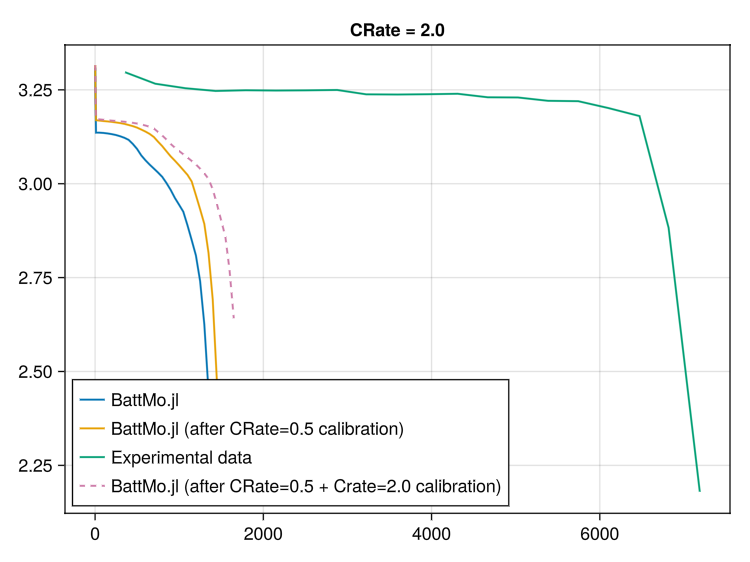

In [21]:
sim_c2 = Simulation(model_setup, cell_parameters_calibrated2, cycling_protocol2)
output2_c = solve(sim_c2, accept_invalid = false);

time_series_2_c = get_output_time_series(output2_c)
t2_c = time_series_2_c[:Time]
V2_c = time_series_2_c[:Voltage]

fig = Figure()
ax = Axis(fig[1, 1], title = "CRate = 2.0")
lines!(ax, t2_0, V2_0, label = "BattMo.jl")
lines!(ax, t2, V2, label = "BattMo.jl (after CRate=0.5 calibration)")

lines!(ax, t_exp_2, V_exp_2, label = "Experimental data")
lines!(ax, t2_c, V2_c, label = "BattMo.jl (after CRate=0.5 + Crate=2.0 calibration)", linestyle = :dash)
axislegend(position = :lb)
fig

### Compare the results of the calibrated model against the experimental data

We can now compare the results of the calibrated model against the experimental data for the 0.5C, 1.0C, and 2.0C discharge curves. Note that we did not calibrate the model for the 1.0C discharge curve, but we still obtain a good fit.

In [22]:
CRates = [0.5, 1.0, 2.0]
outputs_base = []
outputs_calibrated = []

for CRate in CRates
	cycling_protocol["DRate"] = CRate
	simuc = Simulation(model_setup, cell_parameters, cycling_protocol)

	output = solve(simuc, info_level = -1)
	push!(outputs_base, (CRate = CRate, output = output))

    simc = Simulation(model_setup, cell_parameters_calibrated2, cycling_protocol)
	output_c = solve(simc, info_level = -1)

    push!(outputs_calibrated, (CRate = CRate, output = output_c))
end

colors = Makie.wong_colors()

fig = Figure(size = (1200, 600))
ax = Axis(fig[1, 1], ylabel = "Voltage / V", xlabel = "Time / s", title = "Discharge curve")

for (i, data) in enumerate(outputs_base)
    t_i, V_i = get_tV(data.output)
    lines!(ax, t_i, V_i, label = "Simulation (initial) $(round(data.CRate, digits = 2))", color = colors[i])
end

for (i, data) in enumerate(outputs_calibrated)
    t_i, V_i = get_tV(data.output)
	lines!(ax, t_i, V_i, label = "Simulation (calibrated) $(round(data.CRate, digits = 2))", color = colors[i], linestyle = :dash)
end

for (i, df) in enumerate(dfs)
    t_i, V_i = get_tV(df)
    label = "Experimental $(round(CRates[i], digits = 2))"
	lines!(ax, t_i, V_i, linestyle = :dot, label = label, color = colors[i])
end

fig[1, 2] = Legend(fig, ax, "C rate", framevisible = false)
fig

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation

LoadError: UndefVarError: `get_tV` not defined in `Main`
Suggestion: check for spelling errors or missing imports.